# Caption Generation with the Inject and Merge Architectures for the Encoder-Decoder Model

In this notebook, we will be using an inject and merge architecture to generate captions for images from the Flickr8 and Conceptual Caption dataset. 
We will extract the images' features from those two dataset using two different pretrained models (VGG16 and Resnet50) and train different versions of our model with those various data and images features. We will then evaluate and compare the bleu scores on a test dataset after training the model over a similar number of images.


In [15]:

import h5py
import os
from os import listdir
import pandas as pd
import pickle
from pickle import load, dump
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import array


from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout,TimeDistributed, RepeatVector, GlobalAveragePooling2D 
from keras.layers.merge import add

from keras.callbacks import ModelCheckpoint

from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications import resnet50, resnet

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.models import Model

import sys
sys.path.append('/src/capstone-prototype/src/')

import storage
import extraction
import model
from config import settings

%matplotlib inline


# 1 FEATURES EXTRACTION
## 1.1 Pre features extraction using a pretrained VGG16 model and the Flickr8 images

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = vgg16.preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features
 
# extract features from all images
directory = '../../data/Flickr_Data/Flickr_Data/Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('../../data/Flickr_Data/Flickr_Data/features.pkl', 'wb'))

## 1.2 Pre features extraction using a pretrained Resnet50 model and the Flickr8 images

In [ ]:
# extract features from each photo in the directory
def extract_resnet_features(directory):

    
    #Load the ResNet50 model
    image_shape=(224,224,3)
    X_input = Input(image_shape, name="image_input")
    resnet_model = resnet50.ResNet50(weights='imagenet',include_top=True, input_tensor= X_input) 
    model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
    
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the resnet model
        image = resnet.preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features
 
# extract features from all images
directory = '../../data/Flickr_Data/Flickr_Data/Images'
features = extract_resnet_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('../../data/Flickr_Data/Flickr_Data/resnet_features.pkl', 'wb'))


## 1.3 Pre features extraction using a pretrained Resnet50 model and 6000 of the conceptual caption images

In [ ]:
# extract features from each photo in the directory
def extract_resnet_features(images_total_number, set_name, batch_start_index ):

    token_file = open('../../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.token.txt', 'w')
    train_images_file = open('../../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.trainImages.txt', 'w')
    test_images_file = open('../../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.testImages.txt', 'w')
    
    #Load the ResNet50 model
    image_shape=(224,224,3)
    X_input = Input(image_shape, name="image_input")
    resnet_model = resnet50.ResNet50(weights='imagenet',include_top=True, input_tensor= X_input) 
    model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    features = dict()
    idx, missed_idx = 0 , 0

    while (idx < images_total_number + images_total_number*0.1):
        try:
            status, image, caption = storage.read_image(set_name, batch_start_index + idx + missed_idx)                   

            if (int(status) == 200):
                img = Image.fromarray(image)
                img = np.asarray(img.resize(size=(224, 224)))
                img = np.expand_dims(img, axis=0)
                img = resnet.preprocess_input(img)
                # get features
                feature = model.predict(img, verbose=0)
                if (idx + missed_idx)%10 == 0:
                    name = "test" + str(idx + missed_idx)                    
                    images_file = test_images_file
                else:
                    name = "train" + str(idx + missed_idx)
                    images_file = train_images_file

                features[name] = feature
                print('>%s' % name)
                
                line = name + ".jpg#0" + " " + str(caption) + "\n"
                token_file.write(line)
                images_file.write(name + ".jpg\n")
                idx = idx + 1
            else:
                missed_idx = missed_idx + 1
        except KeyError:
            # Ignores files not found - probably an HHTP error when requesting the URL
            missed_idx = missed_idx + 1
            print("-- URL# "+str(batch_start_index + idx + missed_idx)+" storing status not found.")
            continue

    token_file.close()
    train_images_file.close()
    
    return features

# extract features from all images
set_name = "train"
batch_start_index = 0
    

features = extract_resnet_features(18000, set_name, batch_start_index)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('../../data/Flickr_Data/Flickr_Data/CC_resnet_features_18.pkl', 'wb'))


# 2 FEATURES EXTRACTION MODEL CHECK

## 2.1 Features extraction model and check of Input/Output shapes for VGG16

In [ ]:
model = VGG16()
# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize
print(model.summary())

## 2.1 Features extraction model and check of Input/Output shapes for Resnet50

In [ ]:
image_shape=(224,224,3)
X_input = Input(image_shape, name="image_input")
resnet_model = resnet50.ResNet50(weights='imagenet',include_top=True, input_tensor= X_input) 
model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
 
# summarize
print(model.summary())

# 3 CAPTIONS PRE PROCESSING

In [ ]:
import string

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()



In [2]:
import GloVepreprocessing
from config import settings

preprocessor = None

try:
    with open("../../data/preprocessor.pickle", 'rb') as handle:
        preprocessor = pickle.load(handle)
except FileNotFoundError:      
    preprocessor = GloVepreprocessing.GloVepreprocessor()
    with open("../../data/preprocessor.pickle", 'wb') as handle:
        print("before pickle dump")
        pickle.dump(preprocessor, handle)


## 3.1 Create description.txt for Flickr8

In [ ]:
filename = '../../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, '../../data/Flickr_Data/Flickr_Data/descriptions.txt')

## 3.2 Create CC_description.txt for  CC

In [ ]:
filename = '../../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, '../../data/Flickr_Data/Flickr_Data/CC_descriptions.txt')

## 3.3 Test

In [ ]:
df = pd.read_csv('../../data/Flickr_Data/Flickr_Data/descriptions.txt', header=None)
df.head(5)

# 4 Models definition and generator

In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        print(desc)
        print(seq)
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)


In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    return model


In [ ]:
def define_my_model(vocab_size, caption_max_size):
    emb_size = 50
    
    # feature extractor model
    #X_input = Input(shape=(4096,))
    X_input = Input(shape=(2048,))
    X = Dropout(0.5)(X_input)
    X = Dense(emb_size, activation='relu')(X)
    print(X.shape)
    X = RepeatVector(caption_max_size)(X)    
    print(X.shape)
    
    # sequence model
    caption = Input(shape=(caption_max_size,), name="caption_input")  
    Y = Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True, name="wordembed")(caption)
    Y = Dropout(0.5)(Y)
    Y = LSTM(256, return_sequences=True)(Y)
    Y = TimeDistributed(Dense(emb_size))(Y)
    print(Y.shape) 
    
    # decoder model  
    XY = add([X, Y])
    XY = LSTM(128, return_sequences=True)(XY)
    XY = LSTM(512, return_sequences=False)(XY)
    #out = Dense(vocab_size,activation='softmax', name="caption_output")(XY)
    out = Dense(preprocessor.MAX_VOCAB_SIZE, activation='softmax', name="caption_output")(XY)

    model = Model(inputs=[X_input, caption], outputs = out)
    
    # Set embedding matrix
    model.get_layer("wordembed").set_weights([preprocessor.weights])
    model.get_layer("wordembed").trainable = False
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    model.summary()
    return model    





In [ ]:
preprocessor.texts_to_sequences(["startseq the little boy in the grey and dark suit im a minicooper endseq","another freaking stuff", "this"])


In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences_Glove(preprocessor, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence       
        seq = preprocessor.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=preprocessor.MAX_SEQUENCE_LENGTH)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=preprocessor.MAX_VOCAB_SIZE)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)
    

In [ ]:
# data generator, intended to be used in a call to model.fit()
def data_generator_Glove(descriptions, photos, preprocessor):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences_Glove(preprocessor, desc_list, photo)
            yield [[in_img, in_seq], out_word]
   

In [ ]:
def generator(set_name, batch_size, start_index=0):
    #logger = logging.getLogger()        
    batch_start_index = start_index

    while True: 
        X , Yin, Yout = [], [], []
        idx, missed_idx = 0 , 0
        while idx < batch_size:
            try:
                status, _, features, caption = storage.read_image(set_name, batch_start_index + idx + missed_idx)                        
                # encode the sequence       
                seq = preprocessor.texts_to_sequences([str(caption)])[0]
                print("STATUS"+str(status)+str(caption)+str(seq))
                if (int(status) == 200):

                    # split one sequence into multiple X,y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pair
                        in_seq, out_seq = seq[:i], seq[i]
                        print(" THIS IS THE OUT SEQ"+str(out_seq))
                        in_seq = pad_sequences([in_seq], maxlen=preprocessor.MAX_SEQUENCE_LENGTH, padding='post')[0]
                        print(" THIS IS THE IN SEQ"+str(in_seq))
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=preprocessor.VOCAB_SIZE)[0]
                        # store
                        X.append(features)
                        print(features.shape)
                        Yin.append(in_seq)
                        Yout.append(out_seq)

                    idx = idx + 1
                else:
                    missed_idx = missed_idx + 1
            except KeyError:
                # Ignores files not found - probably an HHTP error when requesting the URL
                missed_idx = missed_idx + 1
                logger.info("-- URL# "+str(batch_start_index + idx + missed_idx)+" storing status not found.")
                print("-- URL# "+str(batch_start_index + idx + missed_idx)+" storing status not found.")
                continue


            # Return prep
            X_data = {
                "features_input": X,
                "caption_input": Yin

            }
            Y_data = {
                "caption_output": Yout
            }

            batch_start_index =  batch_start_index + batch_size

        yield([X_data["features_input"],X_data["caption_input"]],[Y_data["caption_output"]])



In [ ]:
X , Yin, Yout = generator("resnet_train", 2, start_index=0)


# 5 Training 

## 5.1 Training of Flickr8 features (VGG16 or Resnet50 extraction) for both models (my_model and define_my_model)¶

In [ ]:
# load training dataset (6K)
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features

# VGG16 features from Flickr8
#train_features = load_photo_features('../data/Flickr_Data/Flickr_Data/features.pkl', train)
# Resnet50 features from Flickr8
train_features = load_photo_features('../data/Flickr_Data/Flickr_Data/resnet_features.pkl', train)

print('Photos: train=%d' % len(train_features))
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
#vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % preprocessor.MAX_VOCAB_SIZE)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
print('Description Length: %d' % preprocessor.MAX_SEQUENCE_LENGTH)

# define the model
#model = define_model(vocab_size, max_length)
model = define_my_model(preprocessor.MAX_VOCAB_SIZE, preprocessor.MAX_SEQUENCE_LENGTH)

# train the model, run epochs manually and save after each epoch
epochs = 3
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator_Glove(train_descriptions, train_features, preprocessor)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('../models/flickr8_resnet_my_model_GLOVE_embed_lala' + str(i) + '.h5')
    

## 5.2 Training of CC features (Resnet50 extraction) for both models (my_model and define_my_model)¶

In [ ]:
# load training dataset (6K)
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/CC_descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features

# 6K Resnet50 features from CC
#train_features = load_photo_features('../data/Flickr_Data/Flickr_Data/CC_resnet_features.pkl', train)
# 18K Resnet50 features from CC
train_features = load_photo_features('../data/Flickr_Data/Flickr_Data/CC_resnet_features_18.pkl', train)

print('Photos: train=%d' % len(train_features))
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
#vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' %  preprocessor.MAX_VOCAB_SIZE)
# determine the maximum sequence length
#caption_max_length = max_length(train_descriptions)
print('Description Length: %d' % preprocessor.MAX_SEQUENCE_LENGTH)

# define the model
#model = define_model(vocab_size, max_length)
model = define_my_model(preprocessor.MAX_VOCAB_SIZE, preprocessor.MAX_SEQUENCE_LENGTH)

# train the model, run epochs manually and save after each epoch
epochs = 6
split = 3 
steps = len(train_descriptions) // split
for i in range(epochs // split):
    # create the data generator
    generator = data_generator_Glove(train_descriptions, train_features, preprocessor)
    # fit for one epoch
    model.fit_generator(generator, epochs=split, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('../models/CC_resnet_my_model_3x6_acc_Glove' + str(i) + '.h5')
    

# 6 EVALUATION

In [ ]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)
 
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
        print(key + " Predicted: "+yhat+ "- Actual: "+desc_list[0])
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



# Adaptation of  the caption generation and model evaluation for Glove embedding

In [3]:

# map an integer to a word
def word_for_id(integer, preprocessor):
    word = '[UNK]'
    try:
        word = preprocessor.idx2word[integer]
    except KeyError:
        pass    
    return word


In [9]:
# generate a description for an image
def generate_desc_Glove(model, preprocessor, photo):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(preprocessor.MAX_SEQUENCE_LENGTH):
        # integer encode input sequence
        sequence = preprocessor.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=preprocessor.MAX_SEQUENCE_LENGTH)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, preprocessor)
        # stop if we cannot map the word
        #if word is None:
           # break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [10]:
# evaluate the skill of the model
def evaluate_model_Glove(model, descriptions, photos, preprocessor):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc_Glove(model, preprocessor, photos[key])
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
        print(key + " Predicted: "+yhat+ "- Actual: "+desc_list[0])
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [16]:
""" 
Generate the caption of a given image
Parameters:
---------------
set_name    validate or train
index       the index of the url/caption in the raw data file
epoch       when loading the trained model, what epoch do we consider 

Returns:
----------
caption    the generated caption

"""
def caption_generation(set_name, index, epoch = 10):  
    
    # Load the ResNet50 model
    image_shape = (settings.image_shape[0],settings.image_shape[1],settings.image_shape[2])
    X_input = Input(image_shape, name="image_input")
    resnet_model = resnet50.ResNet50(weights='imagenet',include_top=True, input_tensor= X_input) 
    features_model = Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[-2].output)
    
    # Extract features
    old_caption, status, features = extraction.get_image_resnet_features(index, features_model, set_name, image_size=(settings.image_shape[0], settings.image_shape[1]))
    _,image, _, _ = storage.read_image(set_name, index)
    
    # Load model and weights
    checkpoint_path = "../../models/chk/"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    predict_model = model.injectAndMerge(preprocessor)
     
    #training_model.load_weights(f"../data/models/w_train_{epoch}.saved")
    predict_model.load_weights(f"{checkpoint_path}wtrain-{epoch:03d}")
    
    # Generate candidate caption
    caption = generate_desc_Glove(predict_model, preprocessor, features)
    
    return old_caption, image, caption

In [ ]:
old_caption, image, caption = caption_generation("train", 80000, epoch = 88)  
print(caption)
print(old_caption)
plt.imshow(image)
plt.show()

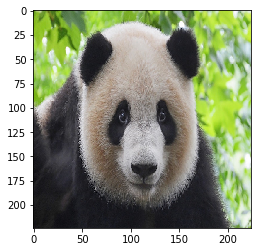

In [34]:
from tensorflow.keras.preprocessing import image
pic = image.load_img("../../data/panda.jpg", target_size = (224,224))
plt.imshow(pic)
plt.show()

## 6.1 Evaluation of Flickr / Resnet50 / define_my_model

In [ ]:
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
#vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % preprocessor.MAX_VOCAB_SIZE)
# determine the maximum sequence length
#max_len = max_length(train_descriptions)
print('Description Length: %d' % preprocessor.MAX_SEQUENCE_LENGTH)
 
# prepare test set
 
# load test set
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('../data/Flickr_Data/Flickr_Data/resnet_features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
#filename = '../data/Flickr_Data/Flickr_Data/resnet_my_model_2.h5'
filename = '../models/flickr8_resnet_my_model_GLOVE_embed_lala2.h5'
#filename = '../data/Flickr_Data/Flickr_Data/my_model_2.h5'
model = load_model(filename)

# evaluate model
#evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
evaluate_model_Glove(model, test_descriptions, test_features, preprocessor)



## 6.2 Evaluation of Flickr / Vgg16 / define_model

In [ ]:
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
caption_max_length = max_length(train_descriptions)
print('Description Length: %d' % caption_max_length)
 
# prepare test set
 
# load test set
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('../data/Flickr_Data/Flickr_Data/features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = '../data/Flickr_Data/Flickr_Data/original_model_2.h5'
model = load_model(filename)

# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, caption_max_length)

## 6.3 Evaluation of CC / Resnet / define_my_model

In [ ]:
# prepare tokenizer on train set
 
# load training dataset (18K)
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/CC_descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
#vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % preprocessor.MAX_VOCAB_SIZE)
# determine the maximum sequence length
#caption_max_length = max_length(train_descriptions)
print('Description Length: %d' % preprocessor.MAX_SEQUENCE_LENGTH)
 
# prepare test set
 
# load test set
filename = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/CC.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('../data/Flickr_Data/Flickr_Data/CC_descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('../data/Flickr_Data/Flickr_Data/CC_resnet_features_18.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = '../models/CC_resnet_my_model_3x6_acc_Glove1.h5'

model = load_model(filename)
# evaluate model
evaluate_model_Glove(model, test_descriptions, test_features, preprocessor)